<a href="https://colab.research.google.com/github/PavanChintha/Machine-Learning/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machines (SVM)
Things covered in this tutorial

* Motivation behind SVM
* Visualizing the Support Vector Classifier
* SVM Regularization
* Classification based on SVM
    * IRIS classification task
    * Eigenfaces (Self exercise)


## Support Vector Machines

Support Vector Machines (SVM) is a supervised machine learning algorithm that is used for both classification and regression problems.
SVM is used for both linear separable data and non-linear separable data.

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points. To separate the two classes of data points, there are many possible hyperplanes that could be chosen. Our objective is to find a plane that has the maximum margin, i.e the maximum distance between data points of both classes. Maximizing the margin distance provides some reinforcement so that future data points can be classified with more confidence.





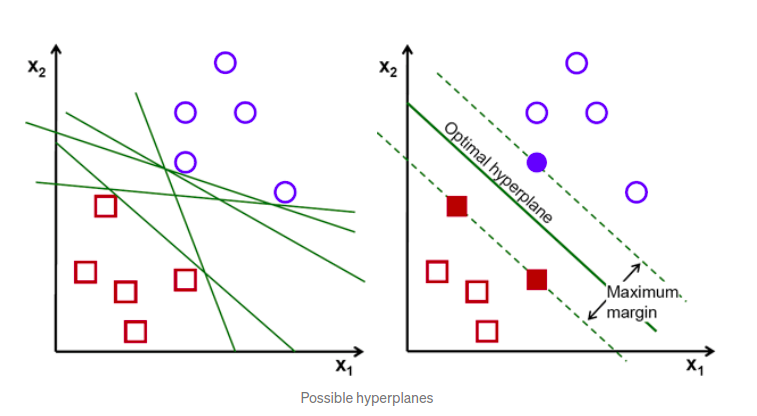




## Motivation behind SVM


We first consider the simple case of a classification task, in which the two classes of points are well separated:



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

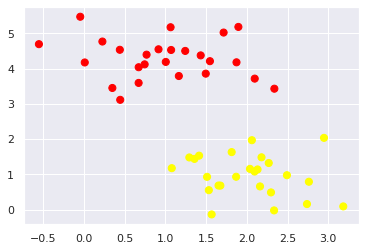

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

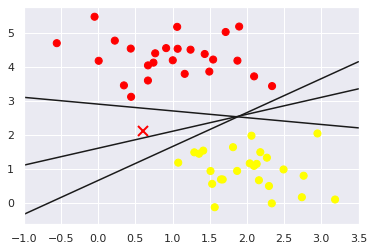

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.
Support vector machines offer one way to improve on this. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look:

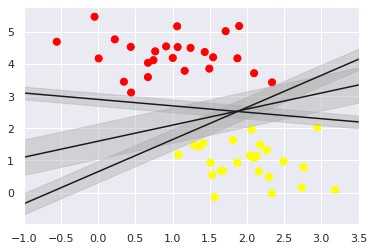

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a maximum margin estimator.

### Fitting a support vector machine 

Now, we'll see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, we'll create a quick convenience function that will plot SVM decision boundaries for us:

In [7]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

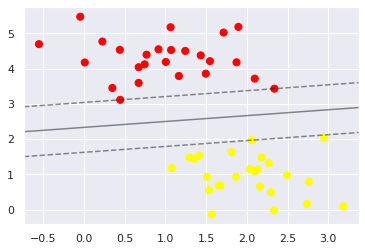

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure. These points are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name. In Scikit-Learn, the identity of these points are stored in the support_vectors_ attribute of the classifier:

In [9]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

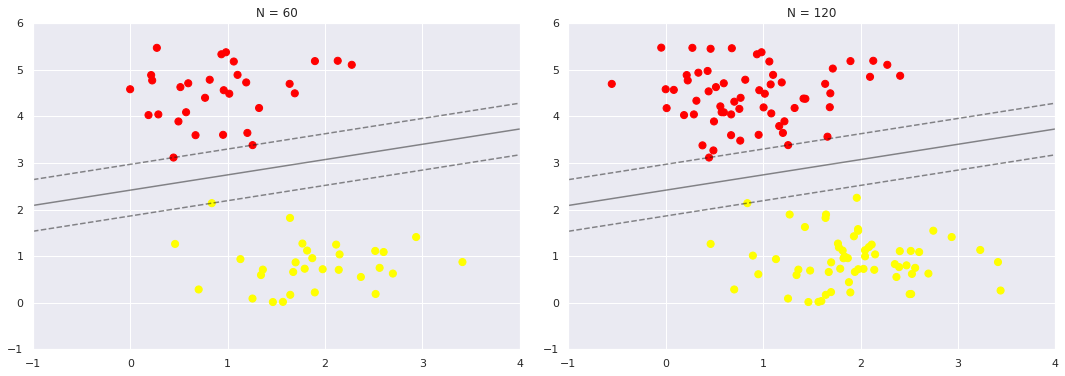

In [10]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

## SVM in linear non-separable cases

In the previous example, we saw that SVM is trying to find the hyperplane that maximizes the margin, with the condition that both classes are classified correctly. But in reality, datasets are probably never linearly separable, so the condition of 100% correctly classified by a hyperplane will never be met.
SVM address non-linearly separable cases by introducing two concepts: 
Soft Margin and Kernel Tricks


To visialize how a non-seperable case looks like, we plot an example scenario using 40 data points

In [11]:
# we create 40 separable points
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [-1] * 20 + [1] * 20

a = np.array([1,1])
X_new = np.vstack((X, a))
Y_new = [-1] * 20 + [1] * 20 + [-1]

a = np.array([2,2])
X_new2 = np.vstack((X, a))
Y_new2 = [-1] * 20 + [1] * 20 + [-1]

Text(0.5, 1.0, 'Linear Not Separable 2')

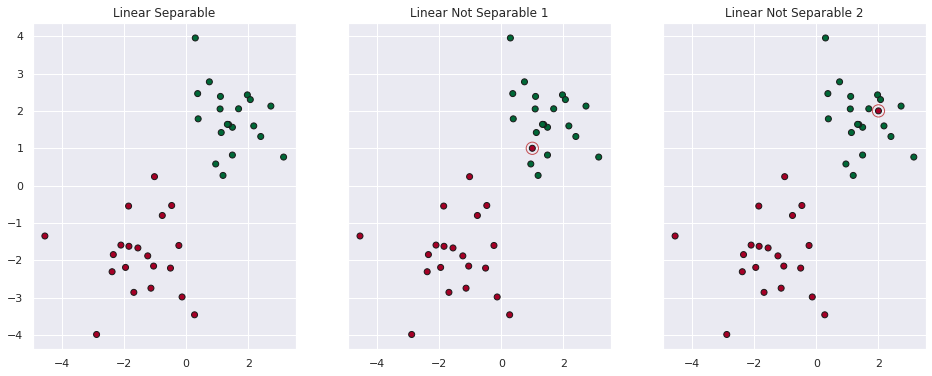

In [12]:
# Visualisation

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6),sharey=True)

ax1.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap='RdYlGn',
                edgecolors='k')
ax1.set_title('Linear Separable')

ax2.scatter(X_new[:, 0], X_new[:, 1], c=Y_new, zorder=10, cmap='RdYlGn',
                edgecolors='k')
ax2.scatter(1, 1, s=150, facecolors='none', zorder=10, 
            edgecolors='r')

ax2.set_title('Linear Not Separable 1')

ax3.scatter(X_new2[:, 0], X_new2[:, 1], c=Y_new2, zorder=10, cmap='RdYlGn',
                edgecolors='k')
ax3.scatter(2, 2, s=150, facecolors='none', zorder=10, 
            edgecolors='r')

ax3.set_title('Linear Not Separable 2')

## Degree of tolerance (Regularization)



How much tolerance(soft) we want to give when finding the decision boundary is an important hyper-parameter for the SVM (both linear and nonlinear solutions). In Sklearn, it is represented as the penalty term — ‘C’. The bigger the C, the more penalty SVM gets when it makes misclassification. Therefore, the narrower the margin is and fewer support vectors the decision boundary will depend on.

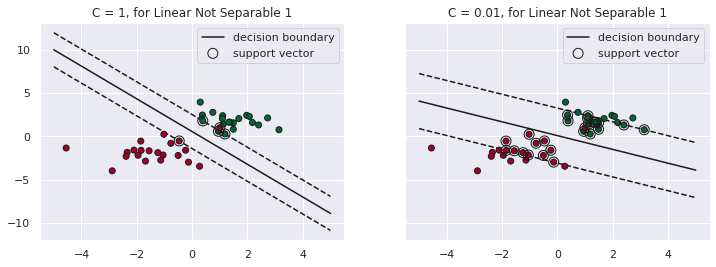

In [13]:
# Illustrate Degree of tolerance 
# penalty term - C in linear SVM
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4),sharey=True)

# fit svm
clf = SVC(kernel='linear', C=1)
clf.fit(X_new, Y_new)

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

# get margin
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

# plot dot
ax1.scatter(X_new[:, 0], X_new[:, 1], c=Y_new, zorder=10, cmap='RdYlGn',
                edgecolors='k')
# plot decision boundary
ax1.plot(xx, yy, 'k-', label = 'decision boundary')
# plot margin
ax1.plot(xx, yy_down, 'k--')
ax1.plot(xx, yy_up, 'k--')
# plot support vector
ax1.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                facecolors='none', zorder=10, edgecolors='k',label = 'support vector')
ax1.set_title('C = 1, for Linear Not Separable 1')

ax1.legend()

# fit svm
clf2 = SVC(kernel='linear', C=0.01)
clf2.fit(X_new, Y_new)

# get the separating hyperplane
w = clf2.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf2.intercept_[0]) / w[1]

# get margin
margin = 1 / np.sqrt(np.sum(clf2.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

# plot dot
ax2.scatter(X_new[:, 0], X_new[:, 1], c=Y_new, zorder=10, cmap='RdYlGn',
                edgecolors='k')
# plot decision boundary
ax2.plot(xx, yy, 'k-', label = 'decision boundary')
# plot margin
ax2.plot(xx, yy_down, 'k--')
ax2.plot(xx, yy_up, 'k--')
# plot support vector
ax2.scatter(clf2.support_vectors_[:, 0], clf2.support_vectors_[:, 1], s=100,
                facecolors='none', zorder=10, edgecolors='k',label = 'support vector')

ax2.set_title('C = 0.01, for Linear Not Separable 1')

ax2.legend()

## Example: IRIS Multi-class Classification  (Exercise)

In its most basic type, SVM doesn’t support multiclass classification. For multiclass classification, the same principle is utilized after breaking down the multi-classification problem into smaller subproblems, all of which are binary classification problems. We now use the same for our exercise on IRIS.

IRIS is a genus of 260–300 species of flowering plants with showy flowers. It takes its name from the greek word for a rainbow,Iris.
In the dataset we have three types of iris:


1.  Iris Setosa
2.  Iris Versicolour
3.  Iris Virginica

We will use a simple SVM classifier for the task




In [14]:
#Define the col names
import pandas as pd
colnames=["sepal_length_in_cm", "sepal_width_in_cm","petal_length_in_cm","petal_width_in_cm", "class"]

#Read the dataset
dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", header = None, names= colnames )

#Data
dataset.head()

,sepal_length_in_cm,sepal_width_in_cm,petal_length_in_cm,petal_width_in_cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


We encode the categorical column using pandas

In [17]:

#Encoding the categorical column
dataset = dataset.replace({"class":  {"Iris-setosa":1,"Iris-versicolor":2, "Iris-virginica":3}})
#Visualize the new dataset
dataset.head()

,sepal_length_in_cm,sepal_width_in_cm,petal_length_in_cm,petal_width_in_cm,class
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


Analyse the data

Text(0.5, 1.0, 'Correlation On iris Classes')

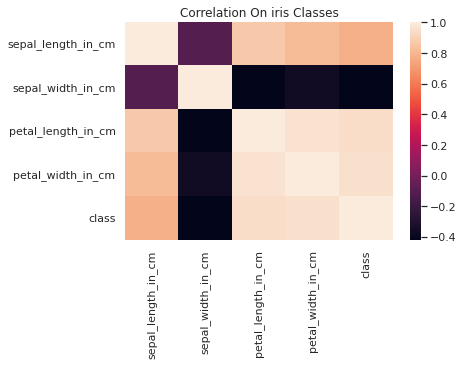

In [18]:
plt.figure(1)
sns.heatmap(dataset.corr())
plt.title('Correlation On iris Classes')

As we can see, the shape of the petals are the most correlationed columns with the type of flowers, with lower correlation there is the sepal length wich also haves a directly correlation and in last place there we have the negative correlation of the sepal width column, but this doen’t mean that is less important, is important but is inverse relationed with the type of flower.
So all the columns are important for the model, in the case we want to quit some columns, the candidates will be the sepal columns with the sepal width in first place.

In [19]:
#Splitting the dataset
X = dataset.iloc[:,:-1]
y = dataset.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


### Exercise 

Fill in the blank spaces mentioned as TODO's for classifying the data

In [22]:
#Create the SVM model
from sklearn.svm import SVC
#classifier =   # TODO - Create an SVM Classifier with a linear kernel.
#Fit the model for the data

classifier = SVC(kernel='linear', C=1E10)

# TODO fit the data to the classifier (X_train, y_train)
classifier.fit(X, y)
#Make the prediction
y_pred = classifier.predict(X_test)

And finally for check the acurracy of the model , we’ll use the confusion matrix and the cross validation

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]
Accuracy: 96.36 %
Standard Deviation: 6.03 %


### Exercise

Comment on your observations

## Example: Face Recognition (Self exercise)

Here we'll take another example of support vector machines in action, the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [24]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:


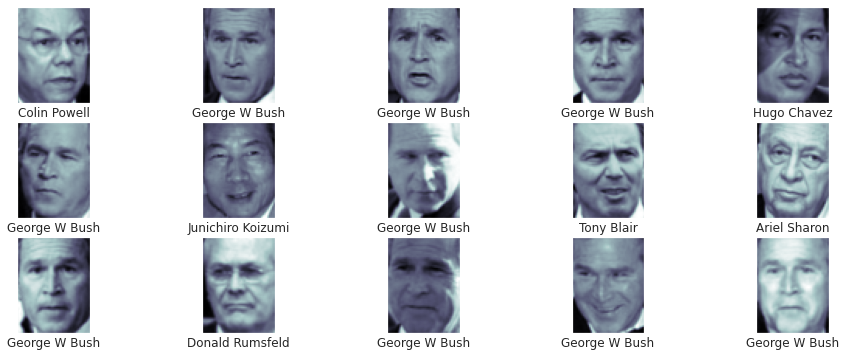

In [25]:

fig, ax = plt.subplots(3, 5,figsize=(16, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels. We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (see In Depth: Principal Component Analysis) to extract 150 fundamental components to feed into our support vector machine classifier. We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [26]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into test and train 


In [27]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use a grid search cross-validation to explore combinations of parameters. Here we will adjust C (which controls the margin hardness) and gamma (which controls the size of the radial basis function kernel), and determine the best model:



In [28]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 55.7 s, sys: 42.7 s, total: 1min 38s
Wall time: 54 s
{'svc__C': 10, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [29]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values:

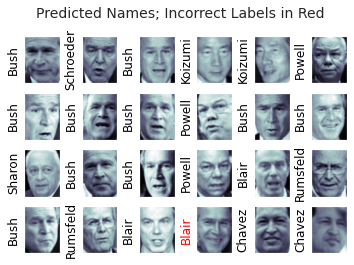

In [30]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s face in the bottom row was mislabeled as Blair). We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:



In [31]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



We might also display the confusion matrix between these classes:


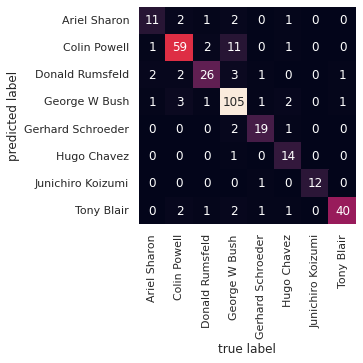

In [32]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation. For this kind of application, one good option is to make use of OpenCV, which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

## References
This notebook has been compiled with the help of the following amazing resources:

- Code and examples: https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05..07-Support-Vector-Machines.ipynb
- IRIS classification task - https://medium.com/@pinnzonandres/iris-classification-with-svm-on-python-c1b6e833522c
- A very simple overview of SVMs : https://towardsdatascience.com/support-vector-machine-simply-explained-fee28eba5496